In [1]:
import os
import pandas as pd
import scanpy as sc
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import scanpy.external as sce

In [2]:
pre_data = sc.read_text('./VEN4FS_scaled.data.txt')

In [3]:
pre_data = sc.AnnData(pre_data.X.T, obs=pre_data.var, var=pre_data.obs)

In [4]:
gene_select_list = pd.read_table('./62cells_Mlevel2_markers(1).txt')

In [5]:
gene_names_list_1 = list(gene_select_list['gene_name'])

In [6]:
len(gene_names_list_1)

3495

In [7]:
sample_name = ['PC17', 'TRI31', 'PC25', 'PC26', 'PC27', 'PC05', 'TRI09', 'TRI23',
       'cVEN01', 'cVEN02', 'cVEN03', 'cVEN04', 'cVEN05', 'cVEN06',
       'cVEN07', 'cVEN08', 'cVEN14', 'PC37', 'PC38', 'PC39', 'PC40',
       'PC41', 'PC42', 'cVEN09', 'cVEN10', 'cVEN11', 'PC33', 'PC34',
       'cVEN12', 'cVEN13', 'PC36', 'PC44', 'PC45', 'PC46', 'PC47', 'PC48',
       'PC49', 'PC50', 'PC51', 'PC53', 'PC54', 'PC55', 'PC56', 'PC57',
       'PC58', 'PC59', 'PC60', 'PC61', 'PC62', 'PC63', 'cVEN15', 'cVEN16',
       'cVEN17', 'cVEN18', 'cVEN19', 'cVEN20', 'PC65', 'PC66', 'cVEN21',
       'PC67', 'PC68', 'cVEN22']



adata = pre_data[sample_name,gene_names_list_1]
print(adata)




View of AnnData object with n_obs × n_vars = 62 × 3495


In [8]:
adata.obs['Cell name'] = adata.obs.index
adata.obs['celltype'] = adata.obs_names.str.extract(r'^(cVEN|PC|ETPC2|ETPC|TRI)', expand=False)

/tmp/ipykernel_635738/100553622.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['Cell name'] = adata.obs.index


In [9]:
adata.obs

,Cell name,celltype
PC17,PC17,PC
TRI31,TRI31,TRI
PC25,PC25,PC
PC26,PC26,PC
PC27,PC27,PC
...,...,...
PC66,PC66,PC
cVEN21,cVEN21,cVEN
PC67,PC67,PC
PC68,PC68,PC


In [10]:
def pre(adata, selected_cell_type):
    # 创建一个映射将所有细胞类型映射为 0
    cell_type_mapping = {cell: 0 for cell in adata.obs['celltype'].unique()}
    # 将选定的细胞类型映射为细胞名
    cell_type_mapping[selected_cell_type] = 1
    # 将细胞类型映射应用到数据框中
    adata.obs['new_celltype'] = adata.obs['celltype'].map(cell_type_mapping)

    return adata



In [11]:
pre(adata, 'cVEN')
# pre(adata, 'cVEN')

AnnData object with n_obs × n_vars = 62 × 3495
    obs: 'Cell name', 'celltype', 'new_celltype'

In [12]:
adata.obs['new_celltype'].value_counts()
# adata.obs['brain_region'].value_counts()

new_celltype
0    40
1    22
Name: count, dtype: int64

In [13]:
Temporal_data = adata
# # 使用默认整数索引
Temporal_data.obs.reset_index(drop=True, inplace=True)
Temporal_data.obs

,Cell name,celltype,new_celltype
0,PC17,PC,0
1,TRI31,TRI,0
2,PC25,PC,0
3,PC26,PC,0
4,PC27,PC,0
...,...,...,...
57,PC66,PC,0
58,cVEN21,cVEN,1
59,PC67,PC,0
60,PC68,PC,0


In [294]:
# 特征选择处理
X = Temporal_data.X
y = Temporal_data.obs['new_celltype'].values

np.int = int
np.float = float
np.bool = bool

In [295]:
rf = RandomForestClassifier(n_jobs=20, class_weight='balanced', max_depth=9)
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', random_state=10)
#4,8
#10,7

#11,7
# find all relevant features - 5 features should be selected
feat_selector.fit(X, y)
feat_selector.support_
# check ranking of features
feat_selector.ranking_
rank = feat_selector.ranking_

In [296]:
X_List = []
for i,item in enumerate(rank):
    if item==1:
        X_List.append(Temporal_data.var_names[i])
            
print(X_List)

['AC005062.1', 'AC020912.1', 'AC092634.5', 'ACKR2', 'AL121895.1', 'AL359547.1', 'AL512590.1', 'C11orf65', 'C9orf43', 'CARD16', 'FLI1', 'GRIK4', 'HCG17', 'IYD', 'KLRG1', 'LAMP3', 'LINC01012', 'LINC01845', 'LINC02002', 'MEIOC', 'OSBPL7', 'PLA2G12B', 'PRKG1', 'SETBP1', 'SLC13A4', 'SLC27A5', 'SLC35F2', 'SP100', 'SP110', 'SPRY4-AS1', 'SULT1C2', 'TADA2A', 'TCEANC2', 'ZNF891']


In [297]:
# 获取选择的基因在adata中的表达情况
expression_data = Temporal_data[:,X_List].X

# 计算每列平均值
mean_expression = expression_data.mean(axis=0).flatten()

# 创建一个 Pandas DataFrame，其中包含基因和它们的平均表达值
gene_expression_df = pd.DataFrame({'Gene': X_List, 'Mean_Expression': mean_expression})

# 按平均表达值降序排序
sorted_gene_expression_df = gene_expression_df.sort_values(by='Mean_Expression', ascending=False)

# 获取排序后的基因列表
sorted_gene_list = sorted_gene_expression_df['Gene'].tolist()

# 打印结果
print(f"Bourta算法选出的基因共{len(sorted_gene_list)}个，基因名如下：{sorted_gene_list}")

Bourta算法选出的基因共34个，基因名如下：['SLC35F2', 'SLC27A5', 'PLA2G12B', 'C11orf65', 'SPRY4-AS1', 'HCG17', 'AC020912.1', 'TCEANC2', 'AL121895.1', 'AL359547.1', 'CARD16', 'AL512590.1', 'SLC13A4', 'AC092634.5', 'SP110', 'SULT1C2', 'LINC01012', 'SETBP1', 'MEIOC', 'ACKR2', 'ZNF891', 'TADA2A', 'LINC01845', 'FLI1', 'OSBPL7', 'IYD', 'SP100', 'LINC02002', 'C9orf43', 'KLRG1', 'LAMP3', 'AC005062.1', 'PRKG1', 'GRIK4']


   Cell name celltype  new_celltype
0       PC17       PC             0
1      TRI31      TRI             0
2       PC25       PC             0
3       PC26       PC             0
4       PC27       PC             0
..       ...      ...           ...
57      PC66       PC             0
58    cVEN21     cVEN             1
59      PC67       PC             0
60      PC68       PC             0
61    cVEN22     cVEN             1

[62 rows x 3 columns]


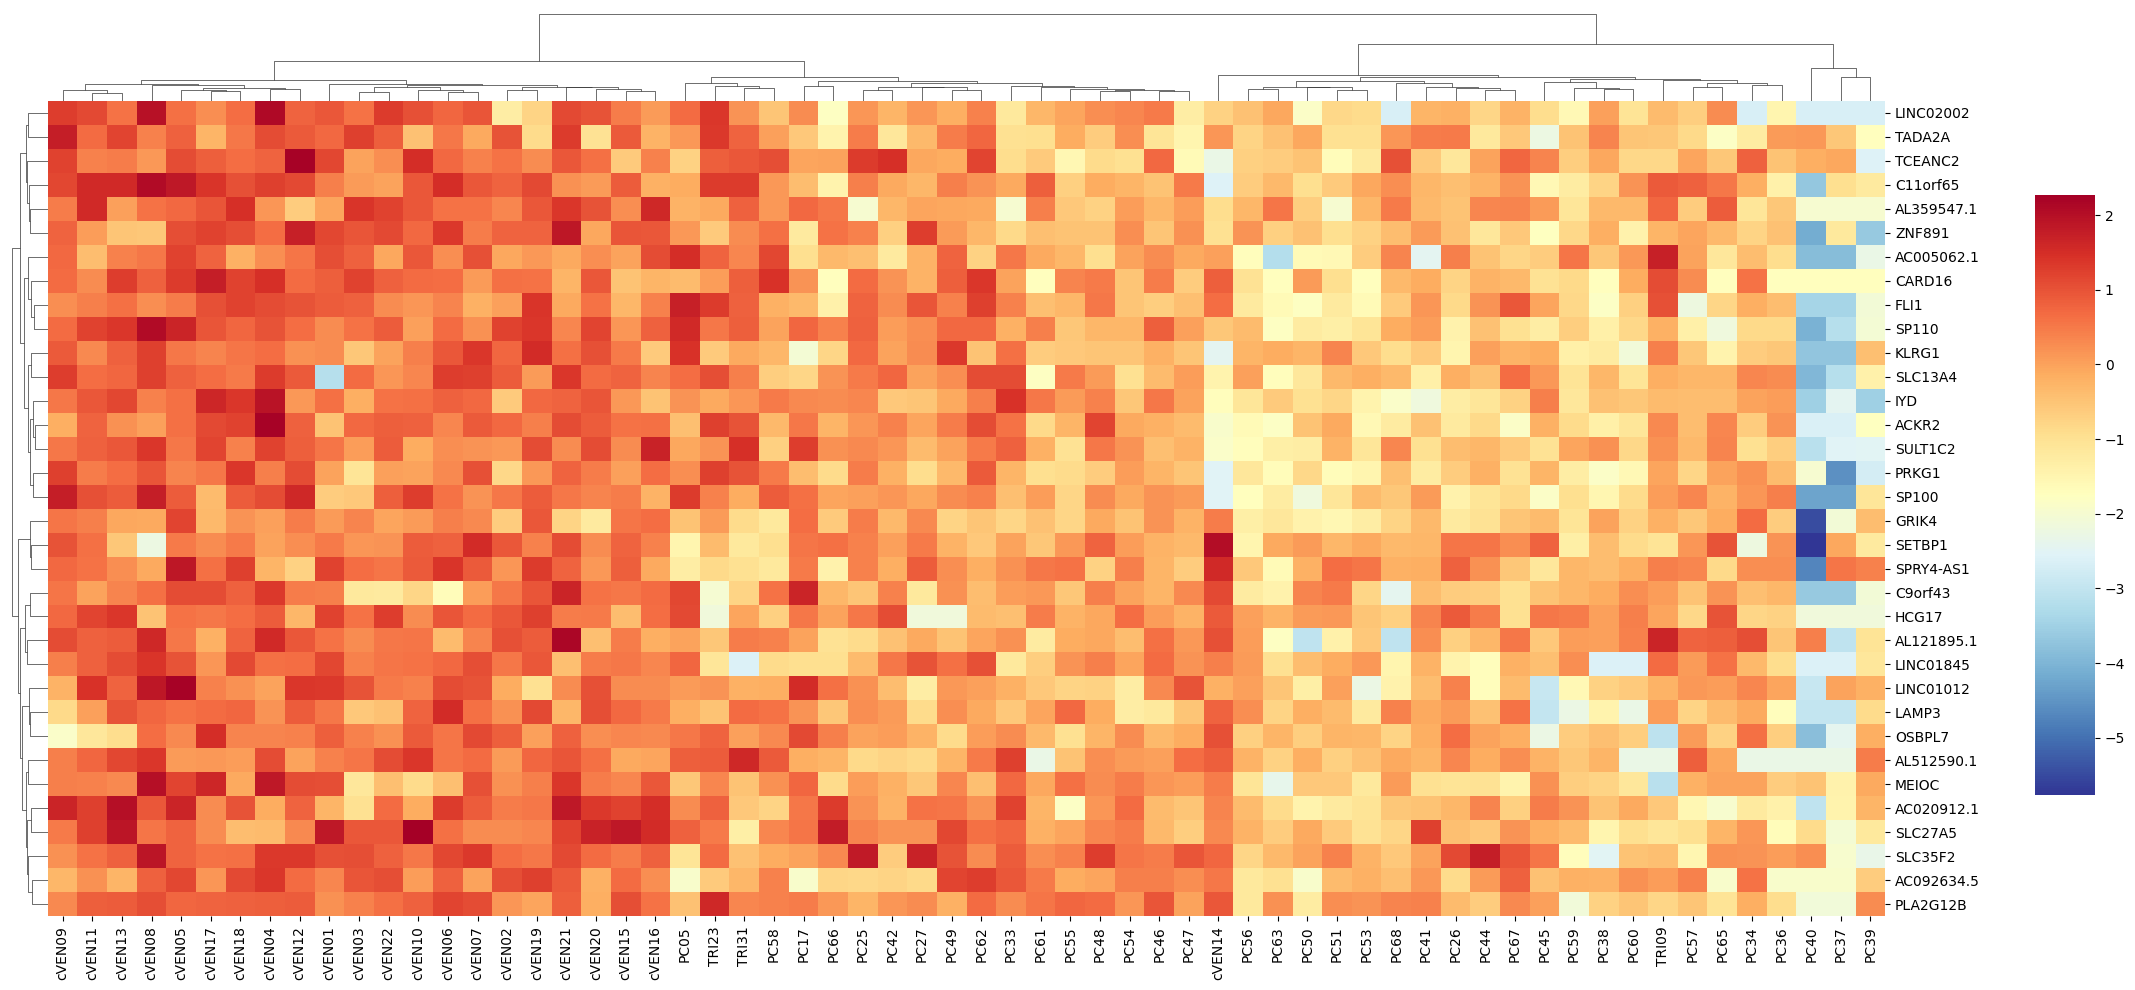

In [299]:
selected_genes_mask1 = Temporal_data.var_names.isin(sorted_gene_list[:])
# 通过布尔掩码更新数据
Temporal_adata_10 = Temporal_data[:, selected_genes_mask1]
print(Temporal_adata_10.obs)

data_exp1 = Temporal_adata_10.X.toarray()
draw_gene1 = Temporal_adata_10.var.index.tolist()
draw_cell1 = Temporal_adata_10.obs['Cell name'].tolist()
df_draw1 = pd.DataFrame(data_exp1, index=draw_cell1, columns=draw_gene1)

clustergrid1 = sns.clustermap(df_draw1.T,col_cluster=True,method='ward',dendrogram_ratio=(0.02, 0.10), cmap='RdYlBu_r', figsize=(20, 10),cbar_pos=(1.02, 0.2, 0.03, 0.6)) # 设置颜色条的位置和大小)#,metric='cosine'


/home/sqjiao/.conda/envs/wanghui/lib/python3.9/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


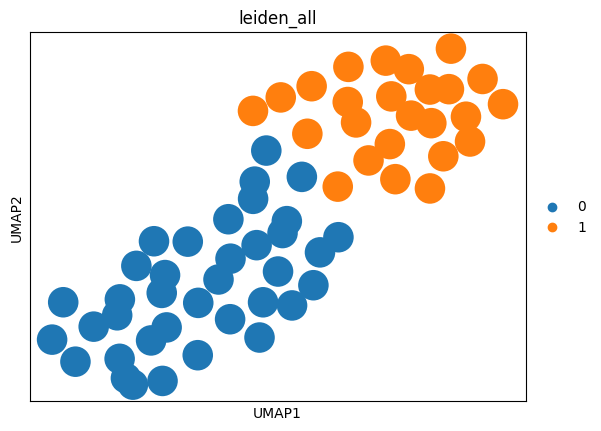

In [280]:
sc.pp.neighbors(Temporal_adata_10, n_neighbors=15)
sc.tl.umap(Temporal_adata_10)
sc.tl.leiden(Temporal_adata_10, key_added="leiden_all", resolution=0.5)
sc.pl.umap(Temporal_adata_10, color="leiden_all", show=False)

# # 在 UMAP 图上添加文本标签（仅为 leiden_all 值为2 的点添加标签）
# for i, (txt, leiden_val) in enumerate(zip(Temporal_adata_30.obs['new index'], Temporal_adata_30.obs['leiden_all'])):
#     if leiden_val == '3':
#         plt.text(Temporal_adata_30.obsm['X_umap'][i, 0], Temporal_adata_30.obsm['X_umap'][i, 1], str(txt))

# 显示图形
plt.show()

In [281]:
Temporal_adata_10.obs[Temporal_adata_10.obs['leiden_all'] == '1']

,Cell name,celltype,new_celltype,leiden_all
1,TRI31,TRI,0,1
5,PC05,PC,0,1
7,TRI23,TRI,0,1
8,cVEN01,cVEN,1,1
9,cVEN02,cVEN,1,1
10,cVEN03,cVEN,1,1
11,cVEN04,cVEN,1,1
12,cVEN05,cVEN,1,1
13,cVEN06,cVEN,1,1
14,cVEN07,cVEN,1,1


In [64]:
Temporal_adata_10.obs[Temporal_adata_10.obs['leiden_all'] == '1']['Cell name'].values

array(['PC17', 'TRI31', 'PC25', 'PC05', 'TRI23', 'cVEN01', 'cVEN02',
       'cVEN03', 'cVEN04', 'cVEN05', 'cVEN06', 'cVEN07', 'cVEN08',
       'cVEN09', 'cVEN10', 'cVEN11', 'cVEN12', 'cVEN13', 'PC49', 'PC58',
       'PC62', 'cVEN15', 'cVEN16', 'cVEN17', 'cVEN18', 'cVEN19', 'cVEN20',
       'cVEN21', 'cVEN22'], dtype=object)

In [65]:
print(len(Temporal_adata_10.obs[Temporal_adata_10.obs['leiden_all'] == '1']))

29
